# Set up

In [1]:
import pandas as pd
import patsy
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Getting data

In [2]:
file_name = '../csvs/element_gameweek_features_v06.csv'

In [3]:
element_gameweek_df = pd.read_csv(file_name)

In [4]:
current_event = 20

In [5]:
last_train_event = 15

In [6]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
]

In [7]:
element_gameweek_df.fillna(
    element_gameweek_df[element_gameweek_df['event'] <= last_train_event].mean(),
    inplace=True
)

In [36]:
element_gameweek_df = element_gameweek_df[element_gameweek_df['rolling_avg_minutes_element_p3'] >= 0]

# Modelling data

## Splitting data

In [37]:
test_fold = [-1 if i <= last_train_event else 0 for i in element_gameweek_df['event']]
ps = PredefinedSplit(test_fold)

In [38]:
for train_index, test_index in ps.split():
    element_gameweek_df_train, element_gameweek_df_test = \
    element_gameweek_df.copy().iloc[train_index], element_gameweek_df.copy().iloc[test_index]

## Scaling data

In [39]:
scaled_feature_cols = [
    i for i in element_gameweek_df.columns if i not in [
        'safe_web_name', 'element', 'event', 'fixture', 'team',
        'opposition_team', 'element_type', 'was_home', 'is_sunday',
        'is_weekday', 'is_late', 'is_early', 'has_high_points_ever_element',
        'total_points', 'minutes', 'rolling_value_points'
    ]
]

scaled_feature_cols

['value',
 'rolling_avg_total_points_element',
 'rolling_max_total_points_element',
 'rolling_avg_bps_element',
 'rolling_avg_bonus_element',
 'rolling_avg_goals_scored_element',
 'rolling_avg_minutes_element',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_completed_passes_element',
 'rolling_avg_recoveries_element',
 'rolling_avg_assists_element',
 'rolling_avg_key_passes_element',
 'rolling_avg_winning_goals_element',
 'rolling_avg_tackled_element',
 'rolling_avg_dribbles_element',
 'rolling_avg_clearances_blocks_interceptions_element',
 'rolling_avg_big_chances_created_element',
 'rolling_avg_target_missed_element',
 'rolling_avg_fouls_element',
 'rolling_avg_tackles_element',
 'rolling_avg_open_play_crosses_element',
 'rolling_avg_offside_element',
 'rolling_avg_big_chances_missed_element',
 'rolling_avg_saves_element',
 'rolling_avg_goals_conceded_element',
 'rolling_avg_attempted_passes_element',
 'rolling_avg_errors_leading_to_goal_element',
 'rolling_avg_errors_leading_to_

In [40]:
scaled_df_train = element_gameweek_df_train.copy()
scaled_df_test = element_gameweek_df_test.copy()
scaled_df = element_gameweek_df.copy()

scaler = StandardScaler().fit(scaled_df_train[scaled_feature_cols].values)

scaled_df_train = scaler.transform(scaled_df_train[scaled_feature_cols].values)
scaled_df_test = scaler.transform(scaled_df_test[scaled_feature_cols].values)
scaled_df = scaler.transform(scaled_df[scaled_feature_cols].values)

element_gameweek_df_train[scaled_feature_cols] = scaled_df_train
element_gameweek_df_test[scaled_feature_cols] = scaled_df_test
element_gameweek_df[scaled_feature_cols] = scaled_df

## Building model

In [41]:
formula = \
'total_points ~ C(element) + C(element_type) + C(team) + C(opposition_team) + ' + \
' + '.join([i for i in element_gameweek_df.columns if i not in
 [
     'safe_web_name',
     'element',
     'event',
     'fixture',
     'team',
     'opposition_team',
     'element_type',
     'minutes',
     'rolling_value_points',
     'total_points',
     
     'expected_total_points_against_opposition_team',
     'rolling_avg_total_points_element_home',
     'rolling_max_total_points_element',
     'rolling_avg_bps_element',
     'expected_total_points_element_home_away',
     'rolling_avg_total_points_element_away',
     'rolling_avg_total_points_own_team',
     'rolling_avg_total_points_against_opposition_team',
     'rolling_avg_minutes_element',
     'rolling_avg_total_points_opposition_team',
     'rolling_avg_dribbles_element',
     'rolling_avg_total_points_against_opposition_team_element_type',
     'rolling_avg_total_points_against_opposition_team_element_type_away',
     'rolling_avg_total_points_against_opposition_team_element_type_home',
     'rolling_avg_goals_conceded_element',
     'rolling_avg_completed_passes_element',
     'rolling_avg_total_points_element_type',
     'rolling_avg_recoveries_element',
     
 ]])

In [42]:
print(formula)

total_points ~ C(element) + C(element_type) + C(team) + C(opposition_team) + was_home + is_sunday + is_weekday + is_early + is_late + value + rolling_avg_total_points_element + has_high_points_ever_element + rolling_avg_bonus_element + rolling_avg_goals_scored_element + rolling_avg_clean_sheets_element + rolling_avg_assists_element + rolling_avg_key_passes_element + rolling_avg_winning_goals_element + rolling_avg_tackled_element + rolling_avg_clearances_blocks_interceptions_element + rolling_avg_big_chances_created_element + rolling_avg_target_missed_element + rolling_avg_fouls_element + rolling_avg_tackles_element + rolling_avg_open_play_crosses_element + rolling_avg_offside_element + rolling_avg_big_chances_missed_element + rolling_avg_saves_element + rolling_avg_attempted_passes_element + rolling_avg_errors_leading_to_goal_element + rolling_avg_errors_leading_to_goal_attempt_element + rolling_avg_own_goals_element + rolling_avg_penalties_concededd_element + rolling_avg_penalties_mis

In [43]:
y, X = patsy.dmatrices(formula, element_gameweek_df, return_type='matrix')

In [44]:
for train_index, test_index in ps.split():
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

## Principal components

In [45]:
X.design_info.column_name_indexes

OrderedDict([('Intercept', 0),
             ('C(element)[T.2]', 1),
             ('C(element)[T.3]', 2),
             ('C(element)[T.4]', 3),
             ('C(element)[T.5]', 4),
             ('C(element)[T.6]', 5),
             ('C(element)[T.7]', 6),
             ('C(element)[T.8]', 7),
             ('C(element)[T.9]', 8),
             ('C(element)[T.10]', 9),
             ('C(element)[T.11]', 10),
             ('C(element)[T.12]', 11),
             ('C(element)[T.13]', 12),
             ('C(element)[T.14]', 13),
             ('C(element)[T.15]', 14),
             ('C(element)[T.16]', 15),
             ('C(element)[T.17]', 16),
             ('C(element)[T.18]', 17),
             ('C(element)[T.19]', 18),
             ('C(element)[T.20]', 19),
             ('C(element)[T.21]', 20),
             ('C(element)[T.22]', 21),
             ('C(element)[T.23]', 22),
             ('C(element)[T.24]', 23),
             ('C(element)[T.25]', 24),
             ('C(element)[T.26]', 25),
           

In [46]:
pca = PCA()
pca.fit(X_train[:,614:])

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

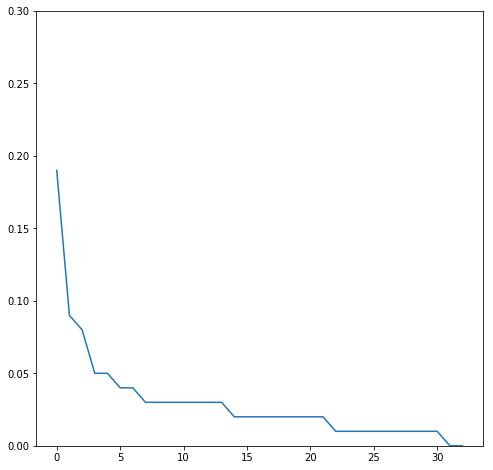

In [47]:
plt.figure(figsize=(8, 8))
plt.plot(pca.explained_variance_ratio_.round(2))
plt.ylim(0, 0.3)
plt.show()

In [48]:
X_train_pca = np.concatenate((X_train[:,:614], pca.transform(X_train[:,614:])), axis=1)
X_train_pca.shape

(3809, 647)

In [49]:
X_test_pca = np.concatenate((X_test[:,:614], pca.transform(X_test[:,614:])), axis=1)
X_test_pca.shape

(1203, 647)

In [50]:
X_pca = np.concatenate((X[:,:614], pca.transform(X[:,614:])), axis=1)
X_pca.shape

(5012, 647)

## Selecting features

### Linear regression

In [51]:
X_lr = np.concatenate((np.ones((len(X_pca), 1)), X_pca[:,567:]), axis=1)
X_train_lr = np.concatenate((np.ones((len(X_train_pca), 1)), X_train_pca[:,567:]), axis=1)
X_test_lr = np.concatenate((np.ones((len(X_test_pca), 1)), X_test_pca[:,567:]), axis=1)

In [52]:
lr_estimator = LinearRegression()
lr_selector = RFECV(lr_estimator, step=1,
                 scoring='neg_mean_squared_error',
                 cv=ps, n_jobs=1, verbose=1)
lr_selector.fit(X_lr, y.ravel())

Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 fe

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [53]:
sum(lr_selector.support_)

50

In [54]:
lr_X_sel = X_lr[:,lr_selector.support_]
lr_X_train_sel = X_train_lr[:,lr_selector.support_]
lr_X_test_sel = X_test_lr[:,lr_selector.support_]

### Ridge regression

In [73]:
ridge_estimator = Ridge(alpha=447)
ridge_selector = RFECV(ridge_estimator, step=1,
                 scoring='neg_mean_squared_error',
                 cv=ps, n_jobs=1, verbose=1)
ridge_selector.fit(X_pca, y.ravel())

Fitting estimator with 647 features.
Fitting estimator with 646 features.
Fitting estimator with 645 features.
Fitting estimator with 644 features.
Fitting estimator with 643 features.
Fitting estimator with 642 features.
Fitting estimator with 641 features.
Fitting estimator with 640 features.
Fitting estimator with 639 features.
Fitting estimator with 638 features.
Fitting estimator with 637 features.
Fitting estimator with 636 features.
Fitting estimator with 635 features.
Fitting estimator with 634 features.
Fitting estimator with 633 features.
Fitting estimator with 632 features.
Fitting estimator with 631 features.
Fitting estimator with 630 features.
Fitting estimator with 629 features.
Fitting estimator with 628 features.
Fitting estimator with 627 features.
Fitting estimator with 626 features.
Fitting estimator with 625 features.
Fitting estimator with 624 features.
Fitting estimator with 623 features.
Fitting estimator with 622 features.
Fitting estimator with 621 features.
F

Fitting estimator with 424 features.
Fitting estimator with 423 features.
Fitting estimator with 422 features.
Fitting estimator with 421 features.
Fitting estimator with 420 features.
Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
Fitting estimator with 412 features.
Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
Fitting estimator with 408 features.
Fitting estimator with 407 features.
Fitting estimator with 406 features.
Fitting estimator with 405 features.
Fitting estimator with 404 features.
Fitting estimator with 403 features.
Fitting estimator with 402 features.
Fitting estimator with 401 features.
Fitting estimator with 400 features.
Fitting estimator with 399 features.
Fitting estimator with 398 features.
F

Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
Fitting estimator with 194 features.
Fitting estimator with 193 features.
Fitting estimator with 192 features.
Fitting estimator with 191 features.
Fitting estimator with 190 features.
Fitting estimator with 189 features.
Fitting estimator with 188 features.
Fitting estimator with 187 features.
Fitting estimator with 186 features.
Fitting estimator with 185 features.
Fitting estimator with 184 features.
Fitting estimator with 183 features.
Fitting estimator with 182 features.
Fitting estimator with 181 features.
Fitting estimator with 180 features.
Fitting estimator with 179 features.
Fitting estimator with 178 features.
Fitting estimator with 177 features.
Fitting estimator with 176 features.
F

Fitting estimator with 623 features.
Fitting estimator with 622 features.
Fitting estimator with 621 features.
Fitting estimator with 620 features.
Fitting estimator with 619 features.
Fitting estimator with 618 features.
Fitting estimator with 617 features.
Fitting estimator with 616 features.
Fitting estimator with 615 features.
Fitting estimator with 614 features.
Fitting estimator with 613 features.
Fitting estimator with 612 features.
Fitting estimator with 611 features.
Fitting estimator with 610 features.
Fitting estimator with 609 features.
Fitting estimator with 608 features.
Fitting estimator with 607 features.
Fitting estimator with 606 features.
Fitting estimator with 605 features.
Fitting estimator with 604 features.
Fitting estimator with 603 features.
Fitting estimator with 602 features.
Fitting estimator with 601 features.
Fitting estimator with 600 features.
Fitting estimator with 599 features.
Fitting estimator with 598 features.
Fitting estimator with 597 features.
F

Fitting estimator with 401 features.
Fitting estimator with 400 features.
Fitting estimator with 399 features.
Fitting estimator with 398 features.
Fitting estimator with 397 features.
Fitting estimator with 396 features.
Fitting estimator with 395 features.
Fitting estimator with 394 features.
Fitting estimator with 393 features.
Fitting estimator with 392 features.
Fitting estimator with 391 features.
Fitting estimator with 390 features.
Fitting estimator with 389 features.
Fitting estimator with 388 features.
Fitting estimator with 387 features.
Fitting estimator with 386 features.
Fitting estimator with 385 features.
Fitting estimator with 384 features.
Fitting estimator with 383 features.
Fitting estimator with 382 features.
Fitting estimator with 381 features.
Fitting estimator with 380 features.
Fitting estimator with 379 features.
Fitting estimator with 378 features.
Fitting estimator with 377 features.
Fitting estimator with 376 features.
Fitting estimator with 375 features.
F

Fitting estimator with 179 features.
Fitting estimator with 178 features.
Fitting estimator with 177 features.
Fitting estimator with 176 features.
Fitting estimator with 175 features.
Fitting estimator with 174 features.
Fitting estimator with 173 features.
Fitting estimator with 172 features.
Fitting estimator with 171 features.
Fitting estimator with 170 features.
Fitting estimator with 169 features.
Fitting estimator with 168 features.
Fitting estimator with 167 features.
Fitting estimator with 166 features.
Fitting estimator with 165 features.
Fitting estimator with 164 features.
Fitting estimator with 163 features.
Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
Fitting estimator with 157 features.
Fitting estimator with 156 features.
Fitting estimator with 155 features.
Fitting estimator with 154 features.
Fitting estimator with 153 features.
F

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=Ridge(alpha=447, copy_X=True, fit_intercept=True, max_iter=None,
                      normalize=False, random_state=None, solver='auto',
                      tol=0.001),
      min_features_to_select=1, n_jobs=1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [74]:
sum(ridge_selector.support_)

16

In [75]:
ridge_X_sel = X_pca[:,ridge_selector.support_]
ridge_X_train_sel = X_train_pca[:,ridge_selector.support_]
ridge_X_test_sel = X_test_pca[:,ridge_selector.support_]

### Lasso regression

In [86]:
lasso_estimator = Lasso(alpha=0.0210)
lasso_selector = RFECV(lasso_estimator, step=1,
                 scoring='neg_mean_squared_error',
                 cv=ps, n_jobs=1, verbose=1)
lasso_selector.fit(X_pca, y.ravel())

Fitting estimator with 647 features.
Fitting estimator with 646 features.
Fitting estimator with 645 features.
Fitting estimator with 644 features.
Fitting estimator with 643 features.
Fitting estimator with 642 features.
Fitting estimator with 641 features.
Fitting estimator with 640 features.
Fitting estimator with 639 features.
Fitting estimator with 638 features.
Fitting estimator with 637 features.
Fitting estimator with 636 features.
Fitting estimator with 635 features.
Fitting estimator with 634 features.
Fitting estimator with 633 features.
Fitting estimator with 632 features.
Fitting estimator with 631 features.
Fitting estimator with 630 features.
Fitting estimator with 629 features.
Fitting estimator with 628 features.
Fitting estimator with 627 features.
Fitting estimator with 626 features.
Fitting estimator with 625 features.
Fitting estimator with 624 features.
Fitting estimator with 623 features.
Fitting estimator with 622 features.
Fitting estimator with 621 features.
F

Fitting estimator with 424 features.
Fitting estimator with 423 features.
Fitting estimator with 422 features.
Fitting estimator with 421 features.
Fitting estimator with 420 features.
Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
Fitting estimator with 412 features.
Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
Fitting estimator with 408 features.
Fitting estimator with 407 features.
Fitting estimator with 406 features.
Fitting estimator with 405 features.
Fitting estimator with 404 features.
Fitting estimator with 403 features.
Fitting estimator with 402 features.
Fitting estimator with 401 features.
Fitting estimator with 400 features.
Fitting estimator with 399 features.
Fitting estimator with 398 features.
F

Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
Fitting estimator with 194 features.
Fitting estimator with 193 features.
Fitting estimator with 192 features.
Fitting estimator with 191 features.
Fitting estimator with 190 features.
Fitting estimator with 189 features.
Fitting estimator with 188 features.
Fitting estimator with 187 features.
Fitting estimator with 186 features.
Fitting estimator with 185 features.
Fitting estimator with 184 features.
Fitting estimator with 183 features.
Fitting estimator with 182 features.
Fitting estimator with 181 features.
Fitting estimator with 180 features.
Fitting estimator with 179 features.
Fitting estimator with 178 features.
Fitting estimator with 177 features.
Fitting estimator with 176 features.
Fitting estimator with 175 features.
Fitting estimator with 174 features.
F

Fitting estimator with 621 features.
Fitting estimator with 620 features.
Fitting estimator with 619 features.
Fitting estimator with 618 features.
Fitting estimator with 617 features.
Fitting estimator with 616 features.
Fitting estimator with 615 features.
Fitting estimator with 614 features.
Fitting estimator with 613 features.
Fitting estimator with 612 features.
Fitting estimator with 611 features.
Fitting estimator with 610 features.
Fitting estimator with 609 features.
Fitting estimator with 608 features.
Fitting estimator with 607 features.
Fitting estimator with 606 features.
Fitting estimator with 605 features.
Fitting estimator with 604 features.
Fitting estimator with 603 features.
Fitting estimator with 602 features.
Fitting estimator with 601 features.
Fitting estimator with 600 features.
Fitting estimator with 599 features.
Fitting estimator with 598 features.
Fitting estimator with 597 features.
Fitting estimator with 596 features.
Fitting estimator with 595 features.
F

Fitting estimator with 398 features.
Fitting estimator with 397 features.
Fitting estimator with 396 features.
Fitting estimator with 395 features.
Fitting estimator with 394 features.
Fitting estimator with 393 features.
Fitting estimator with 392 features.
Fitting estimator with 391 features.
Fitting estimator with 390 features.
Fitting estimator with 389 features.
Fitting estimator with 388 features.
Fitting estimator with 387 features.
Fitting estimator with 386 features.
Fitting estimator with 385 features.
Fitting estimator with 384 features.
Fitting estimator with 383 features.
Fitting estimator with 382 features.
Fitting estimator with 381 features.
Fitting estimator with 380 features.
Fitting estimator with 379 features.
Fitting estimator with 378 features.
Fitting estimator with 377 features.
Fitting estimator with 376 features.
Fitting estimator with 375 features.
Fitting estimator with 374 features.
Fitting estimator with 373 features.
Fitting estimator with 372 features.
F

Fitting estimator with 175 features.
Fitting estimator with 174 features.
Fitting estimator with 173 features.
Fitting estimator with 172 features.
Fitting estimator with 171 features.
Fitting estimator with 170 features.
Fitting estimator with 169 features.
Fitting estimator with 168 features.
Fitting estimator with 167 features.
Fitting estimator with 166 features.
Fitting estimator with 165 features.
Fitting estimator with 164 features.
Fitting estimator with 163 features.
Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
Fitting estimator with 157 features.
Fitting estimator with 156 features.
Fitting estimator with 155 features.
Fitting estimator with 154 features.
Fitting estimator with 153 features.
Fitting estimator with 152 features.
Fitting estimator with 151 features.
Fitting estimator with 150 features.
Fitting estimator with 149 features.
F

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=Lasso(alpha=0.021, copy_X=True, fit_intercept=True,
                      max_iter=1000, normalize=False, positive=False,
                      precompute=False, random_state=None, selection='cyclic',
                      tol=0.0001, warm_start=False),
      min_features_to_select=1, n_jobs=1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [87]:
sum(lasso_selector.support_)

30

In [88]:
lasso_X_sel = X_pca[:,lasso_selector.support_]
lasso_X_train_sel = X_train_pca[:,lasso_selector.support_]
lasso_X_test_sel = X_test_pca[:,lasso_selector.support_]

## Tuning model

### GP tuner

#### Ridge regression

In [92]:
ridge_space  = [Real(10**-5, 10**0, 'log-uniform', name='alpha')]

In [93]:
ridge_gp_model = Ridge()

@use_named_args(ridge_space)
def ridge_objective(**params):
    ridge_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            ridge_gp_model,
#             X,
#             X_pca,
            ridge_X_sel,
            y.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [94]:
ridge_res_gp_arr = []
for i in range(1, 2):
    print('minimisation iteration', i)
    ridge_res_gp = gp_minimize(ridge_objective, ridge_space, n_calls=100, verbose=2)
    ridge_res_gp_arr.append(ridge_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0233
Function value obtained: 9.2375
Current minimum: 9.2375
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0059
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0046
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0046
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0048
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration 

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 0.4902
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.5306
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.7962
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 17 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.7868
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 18 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.6759
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.5030
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 20 started. Searching for the next optimal point.
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 0.5348
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 21 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.4476
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 22 started. Searching for the next optimal point.
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.4743
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 23 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.4779
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.5172
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 25 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.5240
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 26 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 0.5615
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 27 started. Searching for the next optimal point.
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 0.8640
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 0.5953
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 29 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 0.6837
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 0.5476
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 31 started. Searching for the next optimal point.
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 0.4995
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 32 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 0.5538
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 33 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 0.5659
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 34 started. Searching for the next optimal point.
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 0.8839
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 35 started. Searching for the next optimal point.
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 0.9704
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 36 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 0.9718
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 37 started. Searching for the next optimal point.
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 0.9776
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 38 started. Searching for the next optimal point.
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 0.7929
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 39 started. Searching for the next optimal point.
Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 0.7132
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 40 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 0.9132
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 41 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 0.6886
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 0.7498
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 0.6596
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 44 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 0.6496
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 0.7611
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 46 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 0.9462
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 47 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 0.7233
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 48 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 0.9517
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 49 started. Searching for the next optimal point.
Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 1.2558
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 50 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 1.3104
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 51 started. Searching for the next optimal point.
Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 0.7927
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 52 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 0.9682
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 53 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 0.9424
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 54 started. Searching for the next optimal point.
Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 0.8648
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 55 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 0.7129
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 56 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 0.9462
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 57 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 0.8872
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 58 started. Searching for the next optimal point.
Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 0.8003
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 59 started. Searching for the next optimal point.
Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 1.1752
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 60 started. Searching for the next optimal point.
Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 1.7013
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 61 started. Searching for the next optimal point.
Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 1.0845
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 62 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 0.9760
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 64 started. Searching for the next optimal point.
Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 0.9013
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 65 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 1.0799
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 66 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 1.0972
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 67 started. Searching for the next optimal point.
Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 1.7635
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 68 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 1.1436
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 69 started. Searching for the next optimal point.
Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 1.1005
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 70 started. Searching for the next optimal point.
Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 1.3076
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 71 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 0.8609
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 72 started. Searching for the next optimal point.
Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 2.1430
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 73 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 1.3985
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 74 started. Searching for the next optimal point.
Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 1.3971
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 75 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 1.0961
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 76 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 1.1752
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 77 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 1.3878
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 78 started. Searching for the next optimal point.
Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 1.5233
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 79 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 1.8789
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 80 started. Searching for the next optimal point.
Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 1.3449
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 81 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 1.1290
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 82 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 1.6199
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 83 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 1.9773
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 84 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 1.6179
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 85 started. Searching for the next optimal point.
Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 1.2831
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 86 started. Searching for the next optimal point.
Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 1.4919
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 87 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 2.0681
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 88 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 1.3240
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 89 started. Searching for the next optimal point.
Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 1.5593
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 90 started. Searching for the next optimal point.
Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 1.2353
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 91 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 1.4164
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 92 started. Searching for the next optimal point.
Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 1.9507
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 93 started. Searching for the next optimal point.
Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 2.8027
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 94 started. Searching for the next optimal point.
Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 1.6174
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 95 started. Searching for the next optimal point.
Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 2.2972
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 96 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 2.4506
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 97 started. Searching for the next optimal point.
Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 1.8260
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 98 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 2.6547
Function value obtained: 9.2374
Current minimum: 9.2374
Iteration No: 99 started. Searching for the next optimal point.
Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 1.9890
Function value obtained: 9.2377
Current minimum: 9.2374
Iteration No: 100 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 1.7217
Function value obtained: 9.2374
Current minimum: 9.2374


In [64]:
# Full PCA (with elements)
for i in ridge_res_gp_arr:
    print(i.fun)
print('\n')
for i in ridge_res_gp_arr:
    print(i.x)

9.377345474528026


[446.9860094838646]


In [95]:
# Selected PCA (with elements)
for i in ridge_res_gp_arr:
    print(i.fun)
print('\n')
for i in ridge_res_gp_arr:
    print(i.x)

9.237357496571956


[1e-05]


#### Lasso regression

In [96]:
lasso_space  = [Real(10**-5, 10**3, 'log-uniform', name='alpha')]

In [97]:
lasso_gp_model = Lasso()

@use_named_args(lasso_space)
def lasso_objective(**params):
    lasso_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            lasso_gp_model,
#             X,
#             X_pca,
            lasso_X_sel,
            y.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [90]:
lasso_res_gp_arr = []
for i in range(1, 2):
    print('minimisation iteration', i)
    lasso_res_gp = gp_minimize(lasso_objective, lasso_space, n_calls=100, verbose=2)
    lasso_res_gp_arr.append(lasso_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0358
Function value obtained: 9.6544
Current minimum: 9.6544
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0216
Function value obtained: 10.4331
Current minimum: 9.6544
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0207
Function value obtained: 9.2379
Current minimum: 9.2379
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0103
Function value obtained: 10.4331
Current minimum: 9.2379
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0174
Function value obtained: 9.8866
Current minimum: 9.2379
Iteratio

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 0.5858
Function value obtained: 9.2346
Current minimum: 9.2346
Iteration No: 14 started. Searching for the next optimal point.
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 1.2001
Function value obtained: 9.2348
Current minimum: 9.2346
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.5453
Function value obtained: 9.3262
Current minimum: 9.2346
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 0.8255
Function value obtained: 9.2633
Current minimum: 9.2346
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.7658
Function value obtained: 9.2365
Current minimum: 9.2346
Iteration No: 18 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 1.2817
Function value obtained: 9.2346
Current minimum: 9.2346
Iteration No: 31 started. Searching for the next optimal point.
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 1.5725
Function value obtained: 9.2360
Current minimum: 9.2346
Iteration No: 32 started. Searching for the next optimal point.
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 1.7206
Function value obtained: 9.2348
Current minimum: 9.2346
Iteration No: 33 started. Searching for the next optimal point.
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 1.4904
Function value obtained: 9.2350
Current minimum: 9.2346
Iteration No: 34 started. Searching for the next optimal point.
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 1.0351
Function value obtained: 9.2423
Current minimum: 9.2346
Iteration No: 35 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 1.6958
Function value obtained: 9.2346
Current minimum: 9.2346
Iteration No: 41 started. Searching for the next optimal point.
Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 1.9408
Function value obtained: 9.2352
Current minimum: 9.2346
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 1.0386
Function value obtained: 9.2364
Current minimum: 9.2346
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 1.0174
Function value obtained: 9.2391
Current minimum: 9.2346
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 1.1521
Function value obtained: 9.2350
Current minimum: 9.2346
Iteration No: 45 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 1.0252
Function value obtained: 9.2346
Current minimum: 9.2346
Iteration No: 47 started. Searching for the next optimal point.
Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 1.9925
Function value obtained: 9.2348
Current minimum: 9.2346
Iteration No: 48 started. Searching for the next optimal point.
Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 2.0659
Function value obtained: 9.2354
Current minimum: 9.2346
Iteration No: 49 started. Searching for the next optimal point.
Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 1.9490
Function value obtained: 9.2358
Current minimum: 9.2346
Iteration No: 50 started. Searching for the next optimal point.
Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 1.1311
Function value obtained: 9.2377
Current minimum: 9.2346
Iteration No: 51 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 1.2432
Function value obtained: 9.2346
Current minimum: 9.2346
Iteration No: 55 started. Searching for the next optimal point.
Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 1.4607
Function value obtained: 9.2348
Current minimum: 9.2346
Iteration No: 56 started. Searching for the next optimal point.
Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 1.1869
Function value obtained: 9.2366
Current minimum: 9.2346
Iteration No: 57 started. Searching for the next optimal point.
Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 1.3812
Function value obtained: 9.2361
Current minimum: 9.2346
Iteration No: 58 started. Searching for the next optimal point.
Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 1.2748
Function value obtained: 9.2355
Current minimum: 9.2346
Iteration No: 59 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 1.6290
Function value obtained: 9.2346
Current minimum: 9.2346
Iteration No: 62 started. Searching for the next optimal point.
Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 1.6015
Function value obtained: 9.2349
Current minimum: 9.2346
Iteration No: 63 started. Searching for the next optimal point.
Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 1.3520
Function value obtained: 9.2350
Current minimum: 9.2346
Iteration No: 64 started. Searching for the next optimal point.
Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 1.8400
Function value obtained: 9.2348
Current minimum: 9.2346
Iteration No: 65 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 2.5318
Function value obtained: 9.2346
Current minimum: 9.2346
Iteration No: 66 started. Searching for the next optimal point.
Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 1.7926
Function value obtained: 9.2405
Current minimum: 9.2346
Iteration No: 67 started. Searching for the next optimal point.
Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 1.4424
Function value obtained: 9.2347
Current minimum: 9.2346
Iteration No: 68 started. Searching for the next optimal point.
Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 1.6820
Function value obtained: 9.2352
Current minimum: 9.2346
Iteration No: 69 started. Searching for the next optimal point.
Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 1.0200
Function value obtained: 9.2349
Current minimum: 9.2346
Iteration No: 70 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 1.6353
Function value obtained: 9.2346
Current minimum: 9.2346
Iteration No: 74 started. Searching for the next optimal point.
Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 1.8664
Function value obtained: 9.2434
Current minimum: 9.2346
Iteration No: 75 started. Searching for the next optimal point.
Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 1.4918
Function value obtained: 9.2350
Current minimum: 9.2346
Iteration No: 76 started. Searching for the next optimal point.
Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 1.9731
Function value obtained: 9.2347
Current minimum: 9.2346
Iteration No: 77 started. Searching for the next optimal point.
Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 1.8631
Function value obtained: 9.2353
Current minimum: 9.2346
Iteration No: 78 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 2.0866
Function value obtained: 9.2346
Current minimum: 9.2346
Iteration No: 80 started. Searching for the next optimal point.
Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 1.9404
Function value obtained: 9.2369
Current minimum: 9.2346
Iteration No: 81 started. Searching for the next optimal point.
Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 1.4972
Function value obtained: 9.2347
Current minimum: 9.2346
Iteration No: 82 started. Searching for the next optimal point.
Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 2.0917
Function value obtained: 9.2351
Current minimum: 9.2346
Iteration No: 83 started. Searching for the next optimal point.
Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 3.2709
Function value obtained: 9.2349
Current minimum: 9.2346
Iteration No: 84 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 1.9456
Function value obtained: 9.2346
Current minimum: 9.2346
Iteration No: 85 started. Searching for the next optimal point.
Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 1.5256
Function value obtained: 9.2348
Current minimum: 9.2346
Iteration No: 86 started. Searching for the next optimal point.
Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 1.7344
Function value obtained: 9.2357
Current minimum: 9.2346
Iteration No: 87 started. Searching for the next optimal point.
Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 2.0821
Function value obtained: 9.2347
Current minimum: 9.2346
Iteration No: 88 started. Searching for the next optimal point.
Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 2.5194
Function value obtained: 9.2348
Current minimum: 9.2346
Iteration No: 89 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 1.7443
Function value obtained: 9.2346
Current minimum: 9.2346
Iteration No: 90 started. Searching for the next optimal point.
Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 1.8517
Function value obtained: 9.2362
Current minimum: 9.2346
Iteration No: 91 started. Searching for the next optimal point.
Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 2.4468
Function value obtained: 9.2353
Current minimum: 9.2346
Iteration No: 92 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 2.9395
Function value obtained: 9.2351
Current minimum: 9.2346
Iteration No: 93 started. Searching for the next optimal point.
Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 1.5967
Function value obtained: 9.2347
Current minimum: 9.2346
Iteration No: 94 started. Searching for the next optimal point.
Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 1.8422
Function value obtained: 9.2349
Current minimum: 9.2346
Iteration No: 95 started. Searching for the next optimal point.
Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 2.1428
Function value obtained: 9.2809
Current minimum: 9.2346
Iteration No: 96 started. Searching for the next optimal point.
Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 2.3253
Function value obtained: 9.2347
Current minimum: 9.2346
Iteration No: 97 started. Sea

/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 3.3723
Function value obtained: 9.2346
Current minimum: 9.2346
Iteration No: 99 started. Searching for the next optimal point.
Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 2.5962
Function value obtained: 9.2347
Current minimum: 9.2346
Iteration No: 100 started. Searching for the next optimal point.


/home/tom/footbot/venv/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 2.5661
Function value obtained: 9.2346
Current minimum: 9.2346


In [72]:
# Full PCA (with elements)
for i in lasso_res_gp_arr:
    print(i.fun)
print('\n')
for i in lasso_res_gp_arr:
    print(i.x)

9.333908206448204


[0.021043086046061893]


In [98]:
# Selected PCA (with elements)
for i in lasso_res_gp_arr:
    print(i.fun)
print('\n')
for i in lasso_res_gp_arr:
    print(i.x)

9.234649510364758


[0.0001]


# Evaluating model

## Linear regression

In [99]:
lr_model = LinearRegression()
lr_model.fit(lr_X_train_sel, y_train.ravel())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [100]:
# get predictions for test set
lr_y_pred = lr_model.predict(lr_X_test_sel).flatten()

# calculate cross entropy loss for test set
lr_test_loss = (
    mean_absolute_error(y_test, lr_y_pred),
    mean_squared_error(y_test, lr_y_pred),
    r2_score(y_test, lr_y_pred)
)
lr_test_loss

(2.1432605160829605, 9.359283167416827, 0.10136206911744827)

In [101]:
# refit lr_model on all data
lr_model_full = LinearRegression()
lr_model_full.fit(lr_X_sel, y.ravel())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [102]:
# get predictions for whole set
lr_y_pred_full = lr_model_full.predict(lr_X_sel).flatten()

# calculate cross entropy loss for test set
lr_test_loss_full = (
    mean_absolute_error(y, lr_y_pred_full),
    mean_squared_error(y, lr_y_pred_full),
    r2_score(y, lr_y_pred_full)
)
lr_test_loss_full

(2.0332268703773866, 8.147258723238341, 0.14256549136032248)

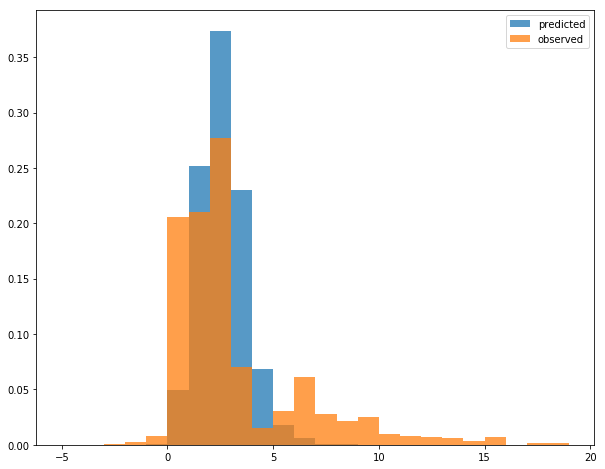

In [103]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(lr_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_test.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

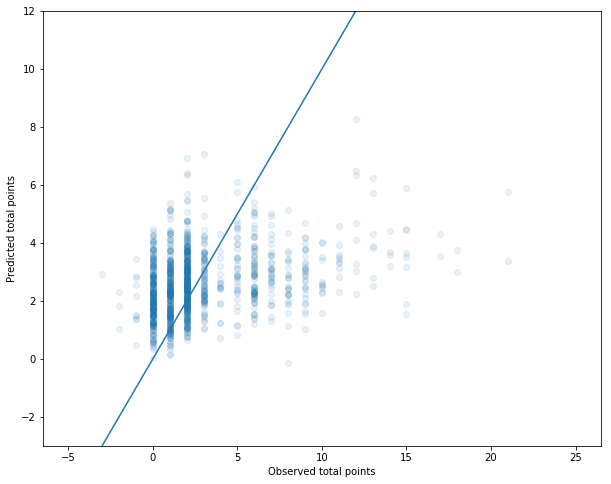

In [104]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_test.ravel()), pd.Series(lr_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

## Ridge regression

### PC with feature selection

In [105]:
ridge_model = Ridge(alpha=1e-5)
ridge_model.fit(ridge_X_train_sel, y_train.ravel())

Ridge(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [106]:
# get predictions for test set
ridge_y_pred = ridge_model.predict(ridge_X_test_sel).flatten()

# calculate cross entropy loss for test set
ridge_test_loss = (
    mean_absolute_error(y_test, ridge_y_pred),
    mean_squared_error(y_test, ridge_y_pred),
    r2_score(y_test, ridge_y_pred)
)

ridge_test_loss

(2.1303806817683095, 9.237357496571956, 0.11306884522514693)

In [107]:
# refit ridge_model on all data
ridge_model_full = Ridge(alpha=27.5)
ridge_model_full.fit(ridge_X_sel, y.ravel())

Ridge(alpha=27.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [108]:
# get predictions for whole set
ridge_y_pred_full = ridge_model_full.predict(ridge_X_sel).flatten()

# calculate cross entropy loss for test set
ridge_test_loss_full = (
    mean_absolute_error(y, ridge_y_pred_full),
    mean_squared_error(y, ridge_y_pred_full),
    r2_score(y, ridge_y_pred_full))
ridge_test_loss_full

(2.0648098356205584, 8.367412520255971, 0.11939604637478973)

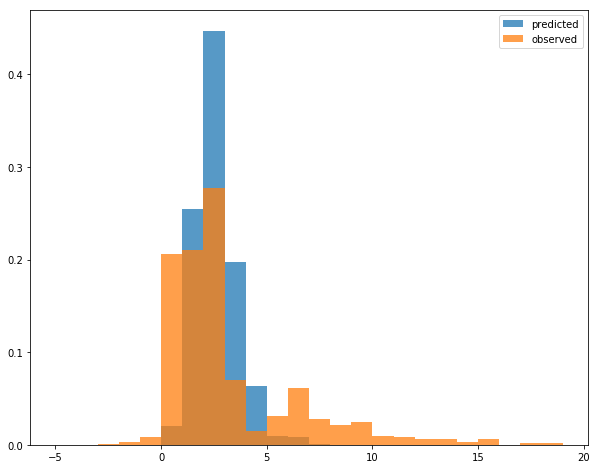

In [109]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(ridge_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_test.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

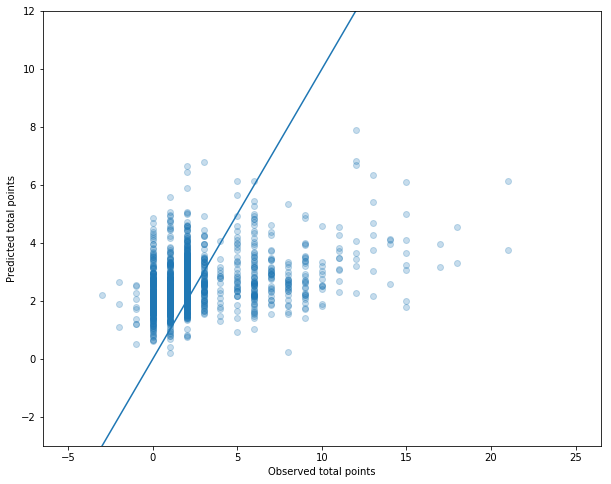

In [110]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_test.ravel()), pd.Series(ridge_y_pred), alpha=0.25)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

## Lasso regression

### PC with feature selection

In [111]:
lasso_model = Lasso(alpha=1e-5)
lasso_model.fit(lasso_X_train_sel, y_train.ravel())

Lasso(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [112]:
# get predictions for test set
lasso_y_pred = lasso_model.predict(lasso_X_test_sel).flatten()

# calculate cross entropy loss for test set
lasso_test_loss = (
    mean_absolute_error(y_test, lasso_y_pred),
    mean_squared_error(y_test, lasso_y_pred),
    r2_score(y_test, lasso_y_pred)
)

lasso_test_loss

(2.1265926973968705, 9.234463611816434, 0.1133467035357032)

In [113]:
# refit lasso_model on all data
lasso_model_full = Lasso(alpha=1e-5)
lasso_model_full.fit(lasso_X_sel, y.ravel())

Lasso(alpha=1e-05, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [114]:
# get predictions for whole set
lasso_y_pred_full = lasso_model_full.predict(lasso_X_sel).flatten()

# calculate cross entropy loss for test set
lasso_test_loss_full = (
    mean_absolute_error(y, lasso_y_pred_full),
    mean_squared_error(y, lasso_y_pred_full),
    r2_score(y, lasso_y_pred_full))
lasso_test_loss_full

(2.0500667504899197, 8.256350656935107, 0.13108442861966862)

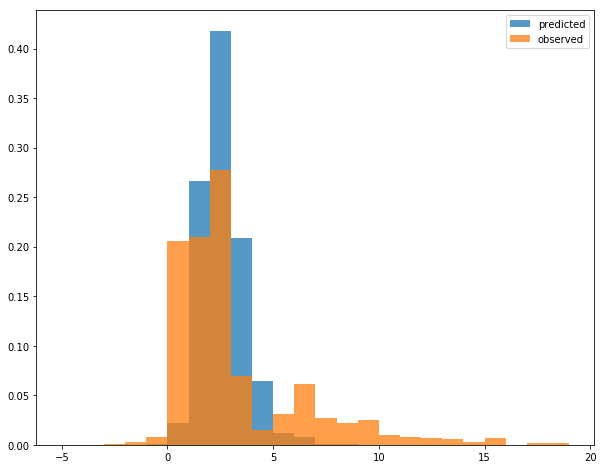

In [115]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(lasso_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_test.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

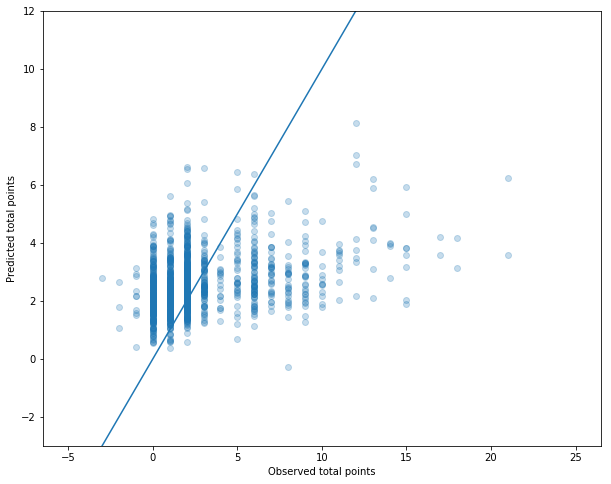

In [116]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_test.ravel()), pd.Series(lasso_y_pred), alpha=0.25)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

## Summary

In [117]:
pd.DataFrame([
    ('Linear regression', lr_test_loss[0], lr_test_loss[1], lr_test_loss[2]),
    ('Ridge regression (selected PC)', ridge_test_loss[0], ridge_test_loss[1], ridge_test_loss[2]),
    ('Lasso regression (selected PC)', lasso_test_loss[0], lasso_test_loss[1], lasso_test_loss[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

,model,MAE,MSE,r2
0,Linear regression,2.143261,9.359283,0.101362
1,Ridge regression (selected PC),2.130381,9.237357,0.113069
2,Lasso regression (selected PC),2.126593,9.234464,0.113347


In [118]:
pd.DataFrame([
    ('Linear regression', lr_test_loss_full[0], lr_test_loss_full[1], lr_test_loss_full[2]),
    ('Ridge regression (selected PC)', ridge_test_loss_full[0], ridge_test_loss_full[1], ridge_test_loss_full[2]),
    ('Lasso regression (selected PC)', lasso_test_loss_full[0], lasso_test_loss_full[1], lasso_test_loss_full[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

,model,MAE,MSE,r2
0,Linear regression,2.033227,8.147259,0.142565
1,Ridge regression (selected PC),2.064810,8.367413,0.119396
2,Lasso regression (selected PC),2.050067,8.256351,0.131084


*Linear Regression*
 - No improvement with PCA (which is odd)
 - Improvement with RFE
 - Improvement with removing elements (overfitting)

*Ridge Regression*
 - Modest improvement with PCA after RFE
 - Improvement with RFE
 - No improvement with removing elements
 
*Lasso Regression*
 - Modest improvement with PCA after RFE
 - Improvement with RFE
 - No improvement with removing elements